In [1]:
# TrackingOff_Stationary_3_ios_background_fetch

In [37]:
import sys
import logging
from uuid import UUID

import emission.core.get_database as edb
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as pydt
import emission.storage.timeseries.abstract_timeseries as esta
import emission.storage.timeseries.timequery as estt
import public_data


logging.getLogger().setLevel(logging.DEBUG)
logging.debug(sys.path)

iphone_ids = ["079e0f1a-c440-3d7c-b0e7-de160f748e35", "c76a0487-7e5a-3b17-a449-47be666b36f6", 
              "c528bcd2-a88b-3e82-be62-ef4f2396967a"]

In [38]:
# pull data from the server (going to take a few minutes)
server_url = 'https://e-mission.eecs.berkeley.edu'

dt1 = pydt.datetime(2016, 6, 30, 0, 30) #datetime.datetime(2016, 6, 24, 22, 0)
dt2 = pydt.datetime(2016, 7, 1, 9, 0)

start_ts = int(dt1.strftime("%s"))
end_ts = int(dt2.strftime("%s"))

phone_ids = iphone_ids 

public_data.request_batched_data(server_url, start_ts, end_ts, phone_ids)

Data loaded to local server!


In [39]:
#type: list of emission.storage.timeseries.builtin_timeseries.BuiltinTimeSeries
iphone_ts = map(lambda u: esta.TimeSeries.get_time_series(UUID(u)), iphone_ids)

#time query specification
dt1 = pydt.datetime(2016, 6, 30, 0, 30) #datetime.datetime(2016, 6, 24, 22, 0)
dt2 = pydt.datetime(2016, 7, 1, 9, 0)

ts1 = int(dt1.strftime("%s"))
ts2 = int(dt2.strftime("%s"))

time_range = estt.TimeQuery("metadata.write_ts", ts1, ts2)


iphone_state_df_list = map(lambda t:t.get_data_df("statemachine/transition", time_range), iphone_ts)
iphone_battery_df_list = map(lambda t:t.get_data_df("background/battery", time_range), iphone_ts)

In [40]:
def get_ranges_df(battery_df, state_df):
    #find start_state_ts & end_state_ts for the period when state=3=tracking_stopped
    tracking_stopped_df = state_df[state_df.curr_state == 3]
    tracking_stopped_df.reset_index(inplace=True)
    start_state_ts = tracking_stopped_df.iloc[0].ts
    #if len(tracking_stopped_df)==1:
    #    end_state_ts = battery_df.iloc[-1].ts
    #else:
    #    end_state_ts = tracking_stopped_df.iloc[-1].ts
    end_state_ts = battery_df.iloc[-1].ts
    
    discharging_df = battery_df[(battery_df.ts >= start_state_ts) & (battery_df.ts <= end_state_ts) 
                                  & ((battery_df.battery_status == 1) )]
    discharging_df.reset_index(inplace=True)
    start_ts = discharging_df.iloc[0].ts
    end_ts = discharging_df.iloc[-1].ts
    
    ranges_df = pd.DataFrame({'start_ts': [start_ts], 'end_ts': [end_ts]})
    return ranges_df

In [41]:
def get_ranges_df_list(battery_df_list, state_df_list):
    ranges_df_list = []
    length = len(battery_df_list)
    for i in range(0, length):
        ranges_df_list.append(get_ranges_df(battery_df_list[i], state_df_list[i]))
    return ranges_df_list

In [42]:
iphone_ranges_df_list = get_ranges_df_list(iphone_battery_df_list, iphone_state_df_list)

iphone_concat_ranges_df = pd.concat([iphone_ranges_df_list[0], iphone_ranges_df_list[1], iphone_ranges_df_list[2]])
#concat_ranges_df = pd.concat([ranges_df_list[0], ranges_df_list[1], ranges_df_list[2], ranges_df_list[3]])
iphone_concat_ranges_df

,end_ts,start_ts
0,1.467365e+09,1.467262e+09
0,1.467366e+09,1.467261e+09
0,1.467347e+09,1.467347e+09


In [43]:
iphone_start_ts = iphone_concat_ranges_df.start_ts.max() 
iphone_end_ts = iphone_concat_ranges_df.end_ts.min() 
print 'iphone_start_ts=' + str(iphone_start_ts) + '\n' + 'iphone_end_ts=' + str(iphone_end_ts)

iphone_start_ts=1467347372.69
iphone_end_ts=1467347376.86


In [44]:
import numpy as np

iphone_xnew = np.arange(iphone_start_ts, iphone_end_ts, 15 * 60) # 15 minutes

In [45]:
import scipy.interpolate as spi
import numpy as np

def get_interpolated(x, y, xnew):
    # fn = spi.interp1d(x=x, y=y, bounds_error=False, fill_value=y.iloc[-1])
    fn = spi.interp1d(x=x, y=y, bounds_error=False)
    #This class returns a function whose call method uses interpolation to find the value of new points.
    return fn(xnew)

In [46]:
def get_interpolated_df(sensor_df, xnew):
    local_dt_new = map(pydt.datetime.fromtimestamp, xnew)
    fmt_time_new = map(lambda dt: dt.isoformat(), local_dt_new)
    #date.isoformat() Return a string representing the date in ISO 8601 format, ‘YYYY-MM-DD’. 
    # -For example, date(2002, 12, 4).isoformat() == '2002-12-04'.
    interpolated_series = get_interpolated(sensor_df.ts, sensor_df.battery_level_pct, xnew)
    # print "interpolated_series = %s" % interpolated_series
    interpolated_df = pd.DataFrame(data={'ts': xnew, 'metadata_write_ts': xnew, 'local_dt': local_dt_new, 'fmt_time': fmt_time_new, 'battery_level_pct': interpolated_series})
    return interpolated_df

In [47]:
iphone_battery_interp_df_list = map(lambda df: get_interpolated_df(df, iphone_xnew), iphone_battery_df_list)

In [48]:
label = ['10m', '30m', '1h', 'None']

About to plot 0
About to plot 1
About to plot 2


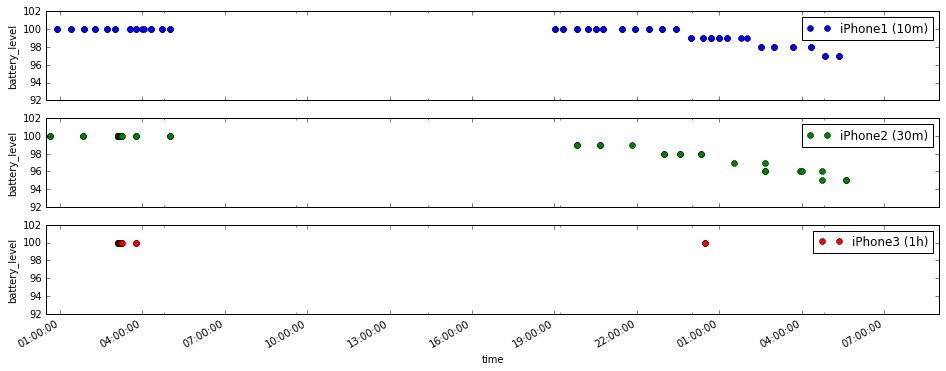

In [49]:
ts_to_dt = lambda t: pydt.datetime.fromtimestamp(t)

#iOS: No interplation on battery data
(afig, aaxes2d) = plt.subplots(ncols=1, nrows=3, sharex=True, sharey=True, figsize=(16,6))
aaxes = aaxes2d.flatten()

#afig.suptitle('iOS background Fetch', fontsize=14, fontweight='bold')
color = ['ob', 'og', 'or', 'oc']
c = ['b', 'g', 'r', 'c']

dt1 = pydt.datetime(2016, 6, 30, 0, 30) #datetime.datetime(2016, 6, 24, 22, 0)
dt2 = pydt.datetime(2016, 7, 1, 9, 0)

for i, df in enumerate(iphone_battery_df_list):
    print "About to plot %d" % i
    df['dt'] = df.ts.apply(ts_to_dt)
    df['hr'] = (df.ts-iphone_start_ts)/3600.0
    df.plot(x='dt', y='battery_level_pct', ylim=(92, 102), xlim=(dt1, dt2), style=color[i], ax=aaxes[i], label="iPhone%s " % (i+1) + '('+label[i]+')')
    #df.plot(x='ts', y='battery_level_pct', kind='scatter', ax=aaxes[i], title="iphone.%s" % (i+1), label=label[i], color=c[i])
    aaxes[i].set_xlabel('time')
    aaxes[i].set_ylabel('battery_level')

afig.savefig('graphs/ios_background_fetch.pdf')

In [ ]:
#iOS: With interplation on battery data 
'''
(ifig, iaxes2d) = plt.subplots(ncols=1, nrows=1, figsize=(16,6))
iaxes = iaxes2d
ifig.suptitle('No Tracking + Stationary_Jun_30-1 (iOS_interpolated_background_fetch)', fontsize=14, fontweight='bold')

for i, df in enumerate(iphone_battery_interp_df_list):
    print "About to plot %d" % i
    df.plot(x='local_dt', y='battery_level_pct', ax=iaxes, label=("iphone-%s " % (i+1))+'('+label[i]+')')
    #df.plot(x='ts', y='battery_level_pct', kind='scatter', ax=iaxes, label="iOS-%s" % i, color=color[i])
    #iaxes.set_xlabel('time')
    iaxes.set_ylabel('batery_level')
'''
#ifig.savefig('interp_Jun_30-1_iOS.png')    

In [ ]:
'''
(ifig, iaxes2d) = plt.subplots(ncols=1, nrows=1, figsize=(16,6))
iaxes = iaxes2d
color = ['ob', 'og', 'or', 'oc']
ifig.suptitle('No Tracking + Stationary_Jun_30-1 (iOS_overlaid)', fontsize=14, fontweight='bold')

for i, df in enumerate(iphone_battery_interp_df_list):
    print "About to plot %d" % i
    df.plot(x='local_dt', y='battery_level_pct', ax=iaxes, label=("iphone-%s " % (i+1))+'('+label[i]+')', legend=True)
    #df.plot(x='ts', y='battery_level_pct', kind='scatter', ax=iaxes, label="iOS-%s" % i, color=color[i])
    #iaxes.set_xlabel('time')
    iaxes.set_ylabel('batery_level')

for i, df in enumerate(iphone_battery_df_list):
    print "About to plot %d" % i
    df['dt'] = df.ts.apply(ts_to_dt)
    df.plot(x='dt', y='battery_level_pct', style=color[i], ax=iaxes, legend=False)
    #df.plot(x='ts', y='battery_level_pct', kind='scatter', ax=aaxes[i], title="iphone.%s" % (i+1), label="iphone-%s" % (i+1), color=color[i])
    
#ifig.savefig('overlaid_Jun_30-1_iOS.png')  
'''

In [ ]:
#iOS
#correlation analysis (tracking_off+stationary)
#generate list of iphone battery series 
iphone_battery_series_list = map(lambda b: b.battery_level_pct, iphone_battery_interp_df_list)
print np.corrcoef(iphone_battery_series_list)
plt.matshow(np.corrcoef(iphone_battery_series_list), cmap=plt.cm.gray)
plt.colorbar()